# Extracting Rules with XAI from RAPP predictions

## Dropout when no exams in last three semesters

In [1]:
import pandas as pd
import numpy as np

from rapp import data

In [2]:
data.connect("data/rapp.db")

In [3]:
sql = "sql/cs_first_term_dropout.sql"
df = data.query_sql_file(sql, data.db_conn)

df

,Geburtsjahr,Geschlecht,Deutsch,AlterEinschreibung,KlausurenGeschrieben,KlausurenBestanden,Ects,DurchschnittsNote,StdevNoteQuadriert,Dropout
0,1976,männlich,1,21,5,4,44.0,1.712500,0.172969,0
1,1984,männlich,1,20,5,5,30.0,3.675000,0.049500,1
2,1981,männlich,1,23,1,1,10.0,2.700000,0.000000,1
3,1985,männlich,1,20,14,14,140.0,1.962500,0.404196,1
4,1983,männlich,1,22,7,7,70.0,2.766667,0.703810,0
...,...,...,...,...,...,...,...,...,...,...
1003,1988,weiblich,1,31,6,6,43.0,1.333333,0.082222,1
1004,1994,männlich,1,25,1,1,5.0,3.300000,0.000000,1
1005,1994,männlich,1,25,1,0,0.0,5.000000,0.000000,1
1006,1986,weiblich,1,33,1,0,0.0,5.000000,0.000000,1


In [4]:
def print_metric(cols, df):
    rows = len(df)
    for col in cols:
        count = len(df[df[col]==1])
        print(f"{col}:", count, f"({count*100./rows} %)")

In [5]:
print_metric(["Dropout"], df)

Dropout: 756 (75.0 %)


In [6]:
df_classification = df.copy(deep=True)
df_classification["StdevNote"] = np.sqrt(df["StdevNoteQuadriert"])
df_classification = df_classification.drop(["StdevNoteQuadriert"], axis=1)

In [7]:
df_classification.head()

,Geburtsjahr,Geschlecht,Deutsch,AlterEinschreibung,KlausurenGeschrieben,KlausurenBestanden,Ects,DurchschnittsNote,Dropout,StdevNote
0,1976,männlich,1,21,5,4,44.0,1.712500,0,0.415895
1,1984,männlich,1,20,5,5,30.0,3.675000,1,0.222486
2,1981,männlich,1,23,1,1,10.0,2.700000,1,0.000000
3,1985,männlich,1,20,14,14,140.0,1.962500,1,0.635764
4,1983,männlich,1,22,7,7,70.0,2.766667,0,0.838934


We need to one-hot encode the gender.

In [8]:
df_classification["Männlich"] = 1*(df_classification["Geschlecht"] == "männlich")
df_classification["Weiblich"] = 1*(df_classification["Geschlecht"] == "weiblich")
df_classification["Divers"] = 1*(df_classification["Geschlecht"] == "divers")

df_classification = df_classification.drop(["Geschlecht", "Geburtsjahr"], axis=1)

In [9]:
df_classification.head()

,Deutsch,AlterEinschreibung,KlausurenGeschrieben,KlausurenBestanden,Ects,DurchschnittsNote,Dropout,StdevNote,Männlich,Weiblich,Divers
0,1,21,5,4,44.0,1.712500,0,0.415895,1,0,0
1,1,20,5,5,30.0,3.675000,1,0.222486,1,0,0
2,1,23,1,1,10.0,2.700000,1,0.000000,1,0,0
3,1,20,14,14,140.0,1.962500,1,0.635764,1,0,0
4,1,22,7,7,70.0,2.766667,0,0.838934,1,0,0


### Prepare train and test set

In [10]:
X = df_classification.drop(["Dropout"], axis=1)
y = df_classification["Dropout"]

feature_names = X.columns

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

### Train classifier

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [13]:
clf = DecisionTreeClassifier(class_weight="balanced", min_impurity_decrease=0.001)

In [14]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', min_impurity_decrease=0.001)

In [15]:
def eval_model(clf):
    y_pred = clf.predict(X_train)
    bacc = balanced_accuracy_score(y_train, y_pred)
    area = roc_auc_score(y_train, y_pred)
    conf = confusion_matrix(y_train, y_pred)
    print("# Trainset")
    print(f"Balanced accuracy: {bacc}")
    print(f"Area under curve: {area}")
    print(f"Confusion Matrix (tn, fp, fn, tp):")
    print(conf)

    y_pred = clf.predict(X_test)
    bacc = balanced_accuracy_score(y_test, y_pred)
    area = roc_auc_score(y_test, y_pred)
    conf = confusion_matrix(y_test, y_pred)
    print("# Testset")
    print(f"Balanced accuracy: {bacc}")
    print(f"Area under curve: {area}")
    print(f"Confusion Matrix (tn, fp, fn, tp):")
    print(conf)


In [16]:
eval_model(clf)

# Trainset
Balanced accuracy: 0.8595588583329389
Area under curve: 0.8595588583329389
Confusion Matrix (tn, fp, fn, tp):
[[169  16]
 [111 460]]
# Testset
Balanced accuracy: 0.6735377168212989
Area under curve: 0.6735377168212989
Confusion Matrix (tn, fp, fn, tp):
[[ 41  26]
 [ 49 136]]


### Display rules learned

In [17]:
%matplotlib inline
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [60, 20]

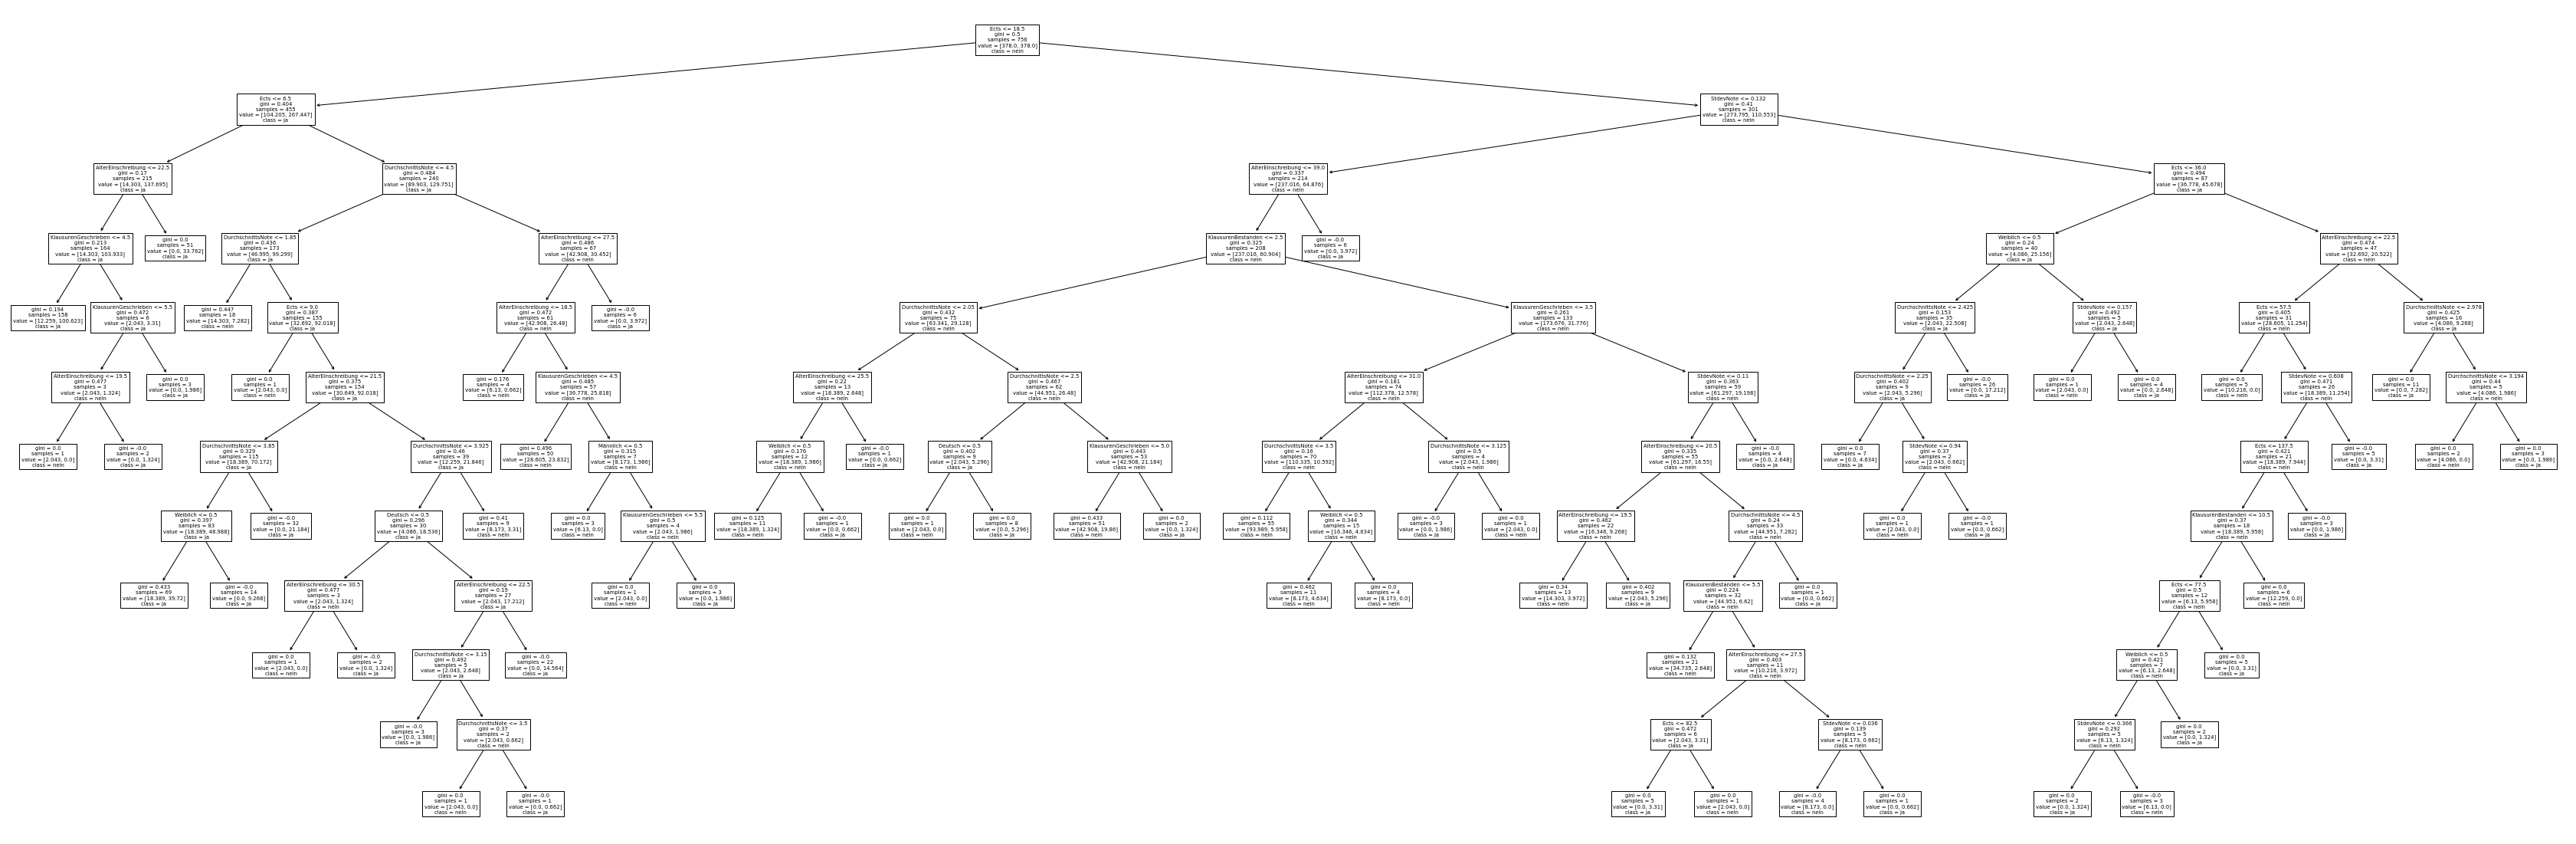

In [18]:
plot_tree(clf, feature_names = feature_names, class_names=["nein", "ja"])
plt.show()

(Right click image -> open in new tab to get a zoomable version.)

### Post pruning of the decision tree

As the decision tree above grew notably large and complex, we want to prune it to achieve a smaller yet comparably performant model. This will also battle the overfitting we observe (higher performances on training than test set).

This cost complexity pruning approach follows the example from https://ranvir.xyz/blog/practical-approach-to-tree-pruning-using-sklearn/ closely.

In [19]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
path

{'ccp_alphas': array([0.        , 0.00132275, 0.00132275, 0.0013418 , 0.00142805,
        0.00146051, 0.00158061, 0.00160299, 0.00162009, 0.00172835,
        0.00178071, 0.0018164 , 0.00183628, 0.00201307, 0.0021124 ,
        0.00211769, 0.00217225, 0.00217944, 0.00288577, 0.00304733,
        0.00317604, 0.00320614, 0.0033306 , 0.00334151, 0.00334523,
        0.00339236, 0.00353565, 0.00380059, 0.00396703, 0.00433705,
        0.00448446, 0.00656327, 0.00780738, 0.00898583, 0.01124568,
        0.01969835, 0.02361052, 0.09327566]),
 'impurities': array([0.19759759, 0.19892035, 0.2002431 , 0.20561031, 0.20846642,
        0.21138743, 0.21296804, 0.21457103, 0.21619112, 0.21791947,
        0.21970018, 0.22333298, 0.23067809, 0.23470423, 0.24315385,
        0.24527154, 0.24961604, 0.25397492, 0.25974646, 0.26888846,
        0.2720645 , 0.27847679, 0.28513798, 0.29182099, 0.29851145,
        0.30868854, 0.31222419, 0.31602478, 0.31999181, 0.32432886,
        0.32881331, 0.33537658, 0.34318396

Text(0, 0.5, 'total impurity of leaves')

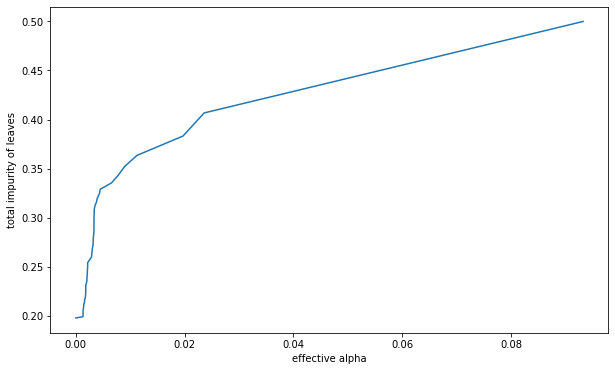

In [20]:
ccp_alphas, impurities = path.ccp_alphas, path.impurities

plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, impurities)
plt.xlabel("effective alpha")
plt.ylabel("total impurity of leaves")

In [21]:
clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha,
                                 class_weight="balanced", min_impurity_decrease=0.001)
    clf.fit(X_train, y_train)
    clfs.append(clf)

Text(0, 0.5, 'total depth')

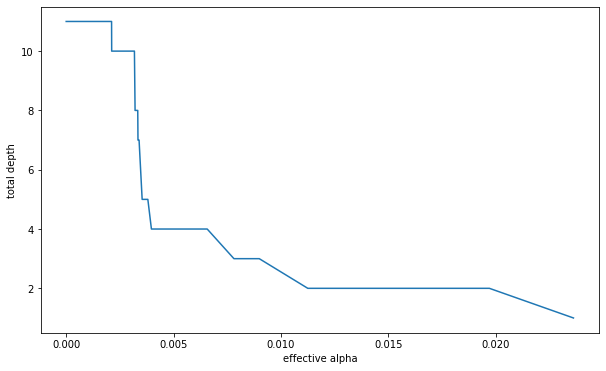

In [22]:
tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.plot(ccp_alphas[:-1], tree_depths[:-1])
plt.xlabel("effective alpha")
plt.ylabel("total depth")


Text(0, 0.5, 'Balanced Accuracy scores')

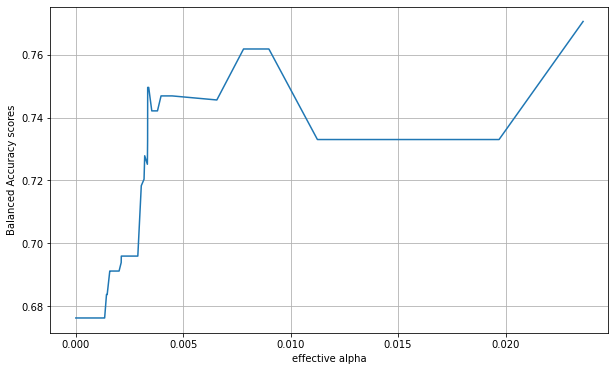

In [23]:
acc_scores = [balanced_accuracy_score(y_test, clf.predict(X_test)) for clf in clfs]

plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas[:-1], acc_scores[:-1])
plt.xlabel("effective alpha")
plt.ylabel("Balanced Accuracy scores")

In [24]:
selected_ccp = 0.009

In [25]:
clf = DecisionTreeClassifier(random_state=0, class_weight="balanced", min_impurity_decrease=0.001,
                             ccp_alpha=selected_ccp)
clf.fit(X_train, y_train)

eval_model(clf)

# Trainset
Balanced accuracy: 0.7437970369669145
Area under curve: 0.7437970369669143
Confusion Matrix (tn, fp, fn, tp):
[[132  53]
 [129 442]]
# Testset
Balanced accuracy: 0.7805970149253731
Area under curve: 0.7805970149253731
Confusion Matrix (tn, fp, fn, tp):
[[ 51  16]
 [ 37 148]]


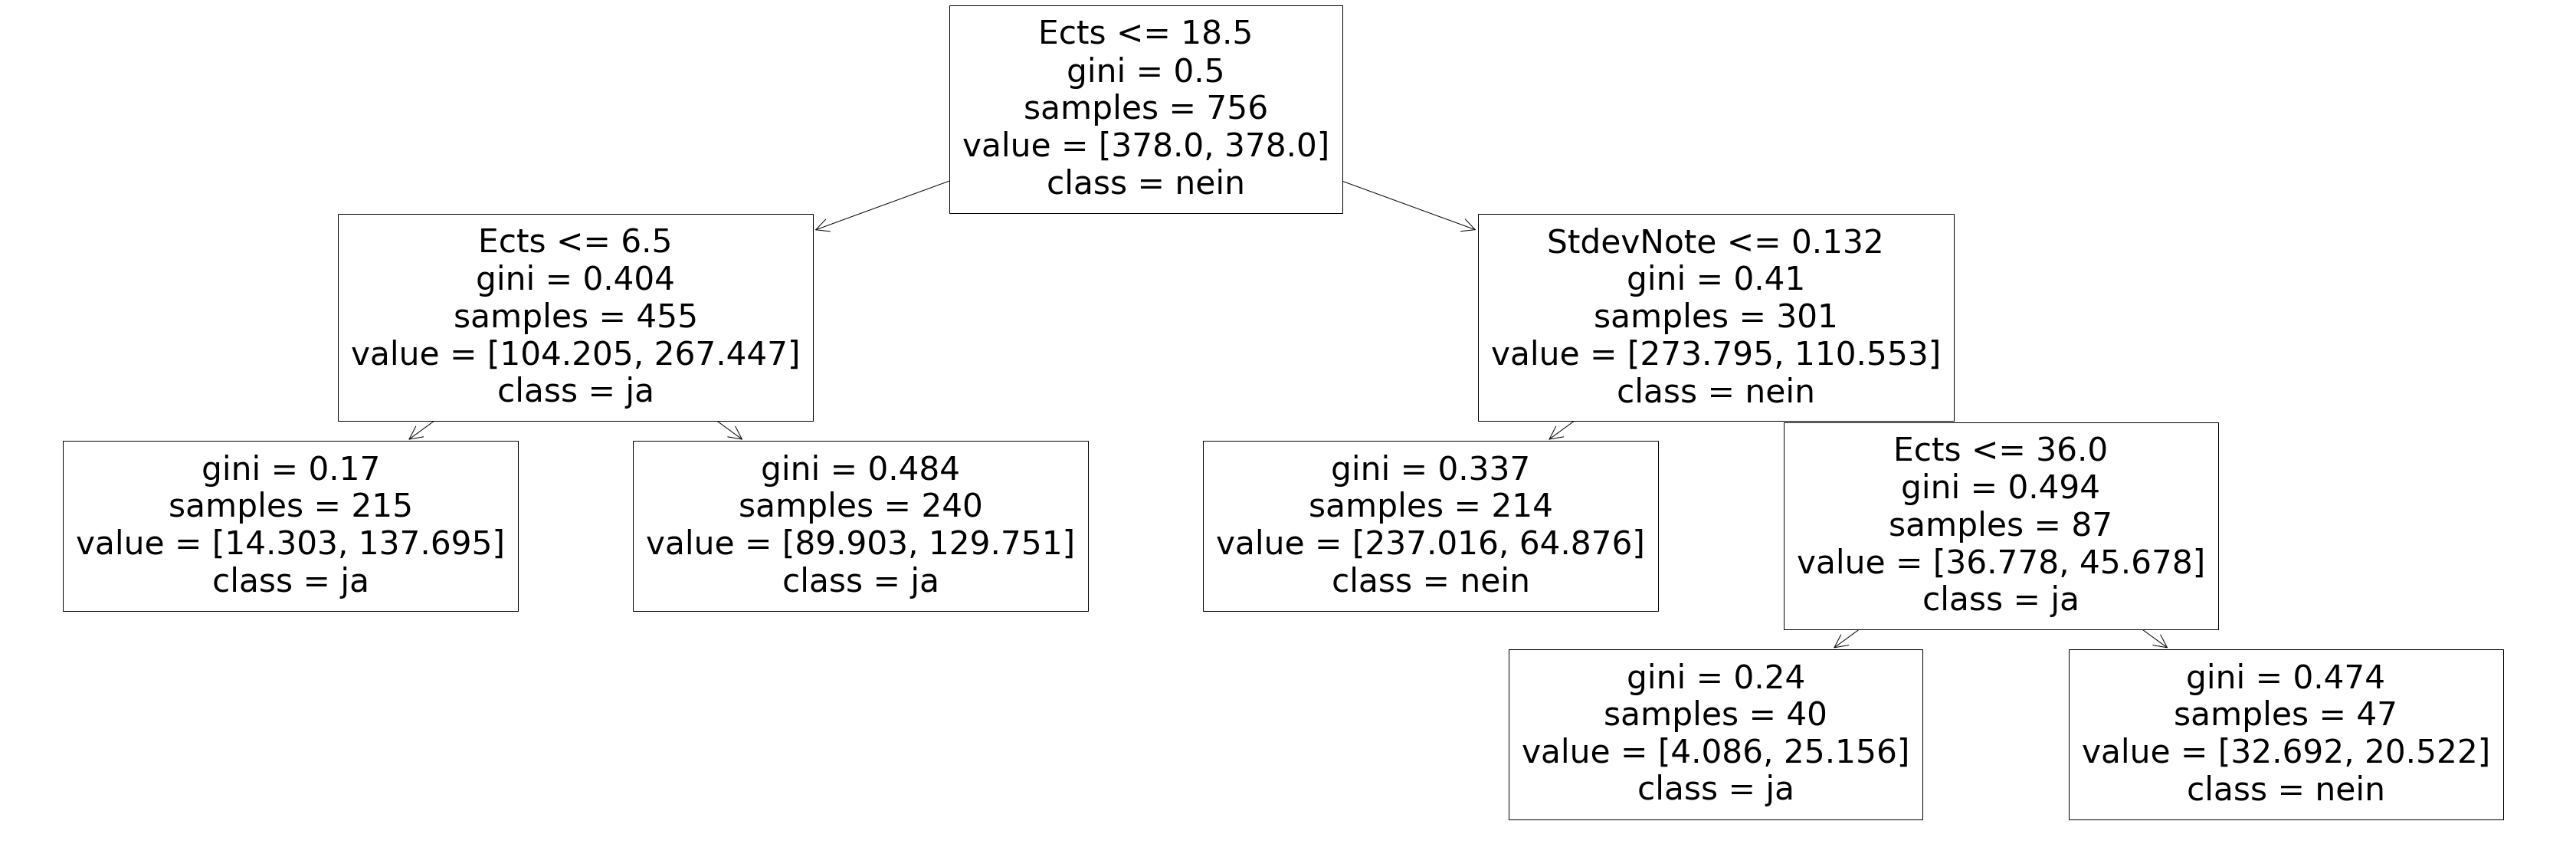

In [26]:
plot_tree(clf, feature_names = feature_names, class_names=["nein", "ja"])
plt.show()

## Alternative Data: Specific modules

The above approach only accounted for ECTS in first semester. As we can see there are some weird edge cases going on:

* Students with more than 36 ECTS
* Focus on standard deviation of the grade

In the following, we will look at some slightly altered version in which we do not investigate the accumulated ECTS as much as the individual modules a computing student would take in their first semester:

* software development and programming
* calculus I
* algorithms and data structures

In [27]:
sql = "sql/cs_first_three_module_dropout.sql"
df = data.query_sql_file(sql, data.db_conn)

df

,Geburtsjahr,Geschlecht,Deutsch,AlterEinschreibung,LABestanden,LAVersuche,ProgBestanden,ProgVersuche,ProgNote,AlgoBestanden,AlgoVersuche,AlgoNote,Dropout
0,1972,männlich,1,35,1,1,1,1,2.7,1,2,2.3,0
1,1987,weiblich,1,20,1,1,1,1,3.7,1,1,3.0,0
2,1987,weiblich,1,20,1,1,0,0,5.0,0,0,5.0,1
3,1987,männlich,1,20,0,0,1,2,3.3,1,2,4.0,1
4,1988,männlich,1,19,1,2,1,1,3.3,1,1,1.3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1270,1990,männlich,1,28,0,0,0,1,5.0,0,0,5.0,1
1271,1989,männlich,1,30,0,0,1,1,1.7,0,0,5.0,1
1272,1998,weiblich,0,20,0,2,0,0,5.0,0,0,5.0,1
1273,1993,männlich,1,26,1,1,0,0,5.0,0,0,5.0,1


In [28]:
print_metric(["Dropout", "LABestanden", "ProgBestanden", "AlgoBestanden"], df)

Dropout: 955 (74.90196078431373 %)
LABestanden: 618 (48.470588235294116 %)
ProgBestanden: 823 (64.54901960784314 %)
AlgoBestanden: 608 (47.68627450980392 %)


In [29]:
# Preprocess data
df_classification = df.copy(deep=True)
df_classification["Männlich"] = 1*(df_classification["Geschlecht"] == "männlich")
df_classification["Weiblich"] = 1*(df_classification["Geschlecht"] == "weiblich")
df_classification["Divers"] = 1*(df_classification["Geschlecht"] == "divers")

df_classification = df_classification.drop(["Geschlecht", "Geburtsjahr"], axis=1)
df_classification.head()

,Deutsch,AlterEinschreibung,LABestanden,LAVersuche,ProgBestanden,ProgVersuche,ProgNote,AlgoBestanden,AlgoVersuche,AlgoNote,Dropout,Männlich,Weiblich,Divers
0,1,35,1,1,1,1,2.7,1,2,2.3,0,1,0,0
1,1,20,1,1,1,1,3.7,1,1,3.0,0,0,1,0
2,1,20,1,1,0,0,5.0,0,0,5.0,1,0,1,0
3,1,20,0,0,1,2,3.3,1,2,4.0,1,1,0,0
4,1,19,1,2,1,1,3.3,1,1,1.3,0,1,0,0


In [30]:
X = df_classification.drop(["Dropout"], axis=1)
y = df_classification["Dropout"]

feature_names = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)


clf = DecisionTreeClassifier(random_state=0, class_weight="balanced", min_impurity_decrease=0.001)
clf.fit(X_train, y_train)
eval_model(clf)

# Trainset
Balanced accuracy: 0.9341006120316465
Area under curve: 0.9341006120316466
Confusion Matrix (tn, fp, fn, tp):
[[227   4]
 [ 83 642]]
# Testset
Balanced accuracy: 0.8478016609672692
Area under curve: 0.8478016609672692
Confusion Matrix (tn, fp, fn, tp):
[[ 77  12]
 [ 39 191]]


The data with the explicit grades already leads to more accurate results as we can see.

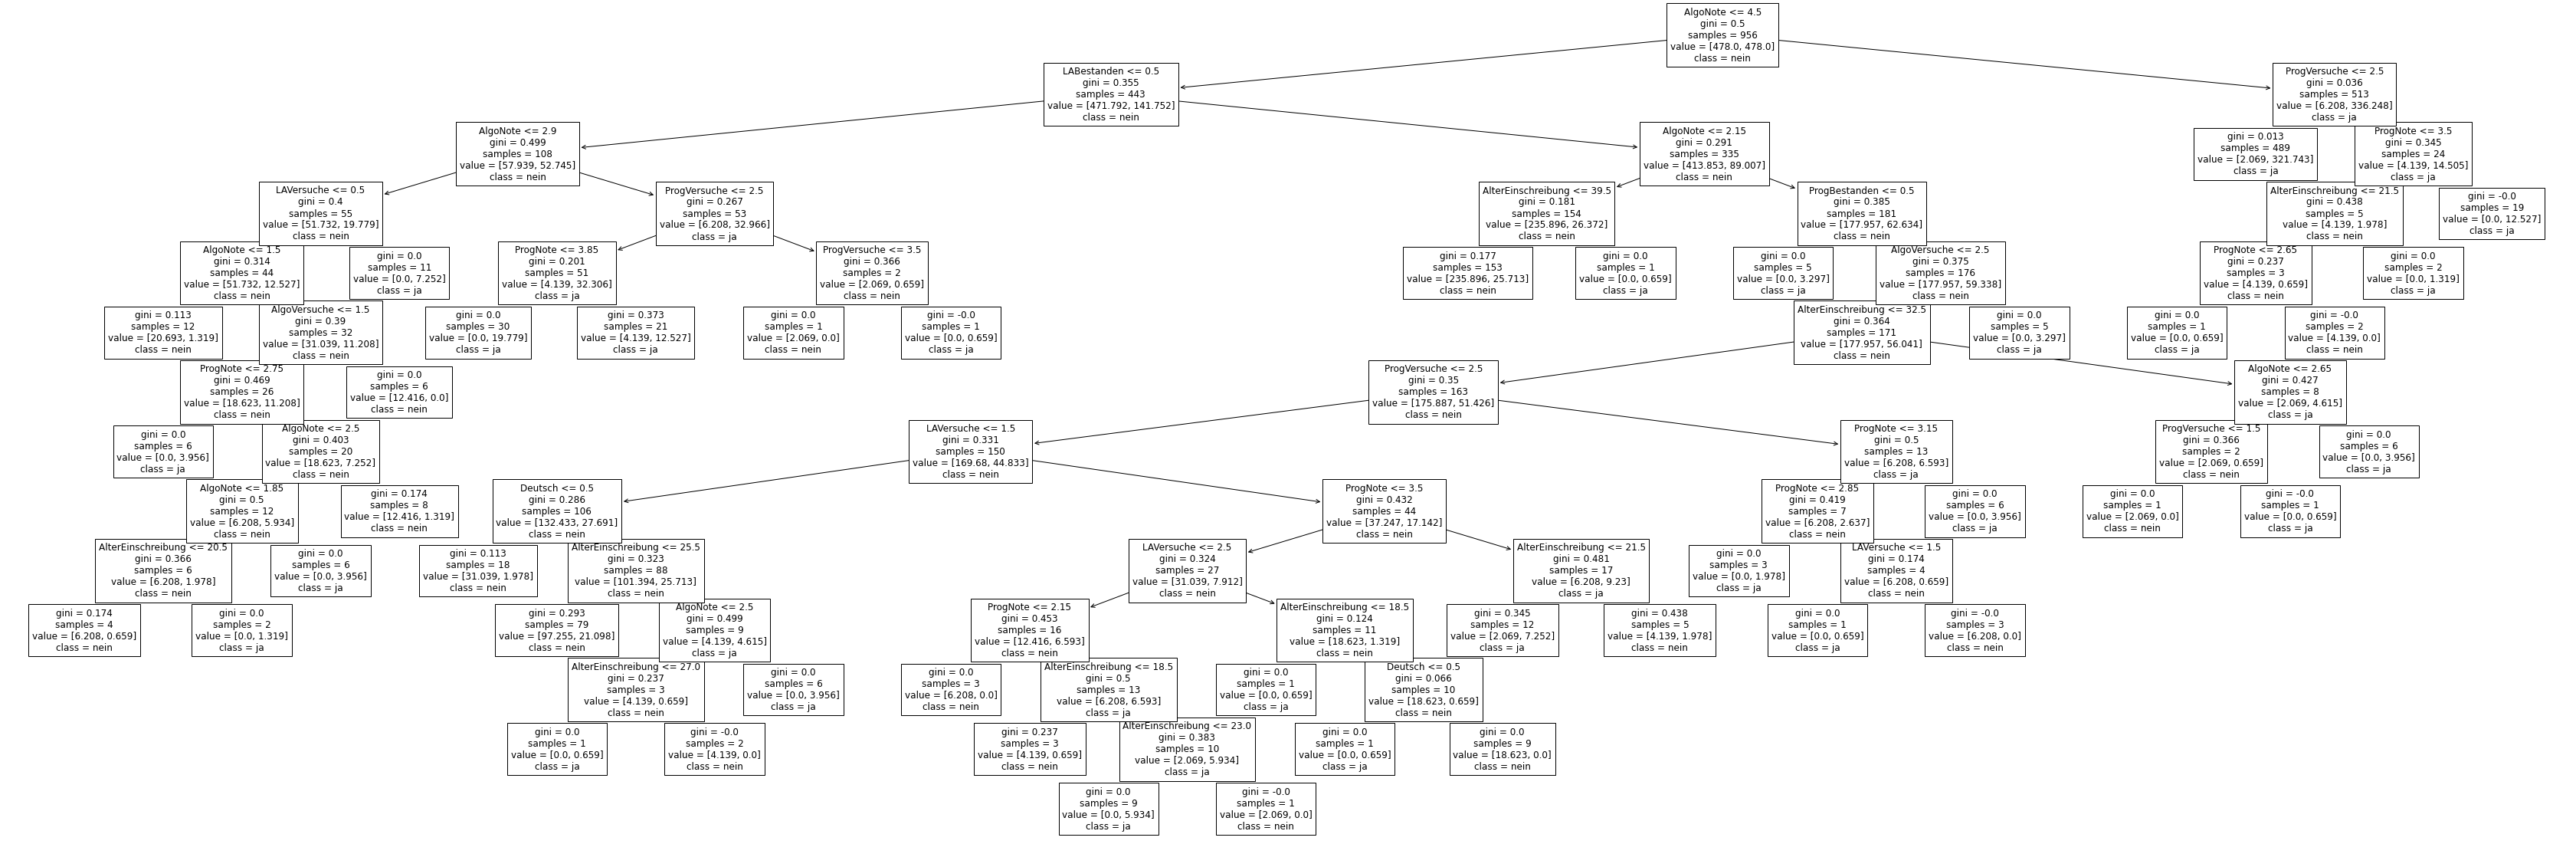

In [31]:
plot_tree(clf, feature_names = feature_names, class_names=["nein", "ja"])
plt.show()

### Post pruning

In [32]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
path

{'ccp_alphas': array([0.        , 0.00104603, 0.00104603, 0.00111868, 0.00116687,
        0.00118977, 0.00118977, 0.00124688, 0.00128811, 0.00159699,
        0.00161005, 0.00189119, 0.00194287, 0.00218771, 0.0022081 ,
        0.00235593, 0.00257456, 0.00262533, 0.00262675, 0.00282522,
        0.00292727, 0.00387944, 0.00670193, 0.00883616, 0.01689863,
        0.01702738, 0.25921128]),
 'impurities': array([0.11316665, 0.11421268, 0.1152587 , 0.11637738, 0.11754425,
        0.11873402, 0.11992379, 0.12117067, 0.12374688, 0.12534387,
        0.12695392, 0.12884511, 0.13078798, 0.1373511 , 0.1395592 ,
        0.14898293, 0.16185571, 0.16448104, 0.17498804, 0.18063848,
        0.18356574, 0.19132462, 0.19802655, 0.20686271, 0.22376133,
        0.24078872, 0.5       ])}

Text(0, 0.5, 'Balanced Accuracy scores')

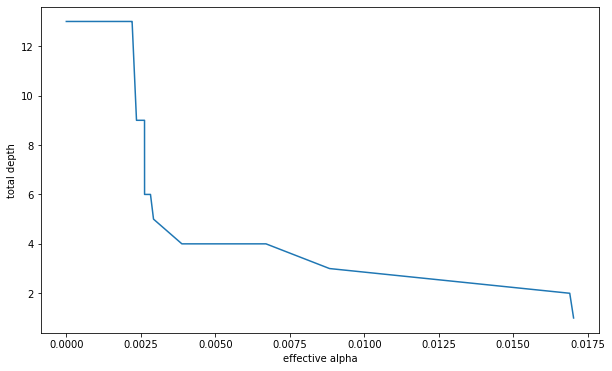

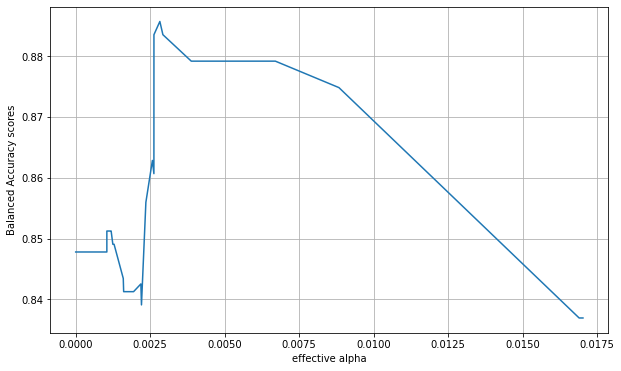

In [33]:
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha,
                                 class_weight="balanced", min_impurity_decrease=0.001)
    clf.fit(X_train, y_train)
    clfs.append(clf)

tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.plot(ccp_alphas[:-1], tree_depths[:-1])
plt.xlabel("effective alpha")
plt.ylabel("total depth")


acc_scores = [balanced_accuracy_score(y_test, clf.predict(X_test)) for clf in clfs]

plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas[:-1], acc_scores[:-1])
plt.xlabel("effective alpha")
plt.ylabel("Balanced Accuracy scores")

# Trainset
Balanced accuracy: 0.8903657262277952
Area under curve: 0.8903657262277952
Confusion Matrix (tn, fp, fn, tp):
[[224   7]
 [137 588]]
# Testset
Balanced accuracy: 0.8856863702979971
Area under curve: 0.885686370297997
Confusion Matrix (tn, fp, fn, tp):
[[ 88   1]
 [ 50 180]]


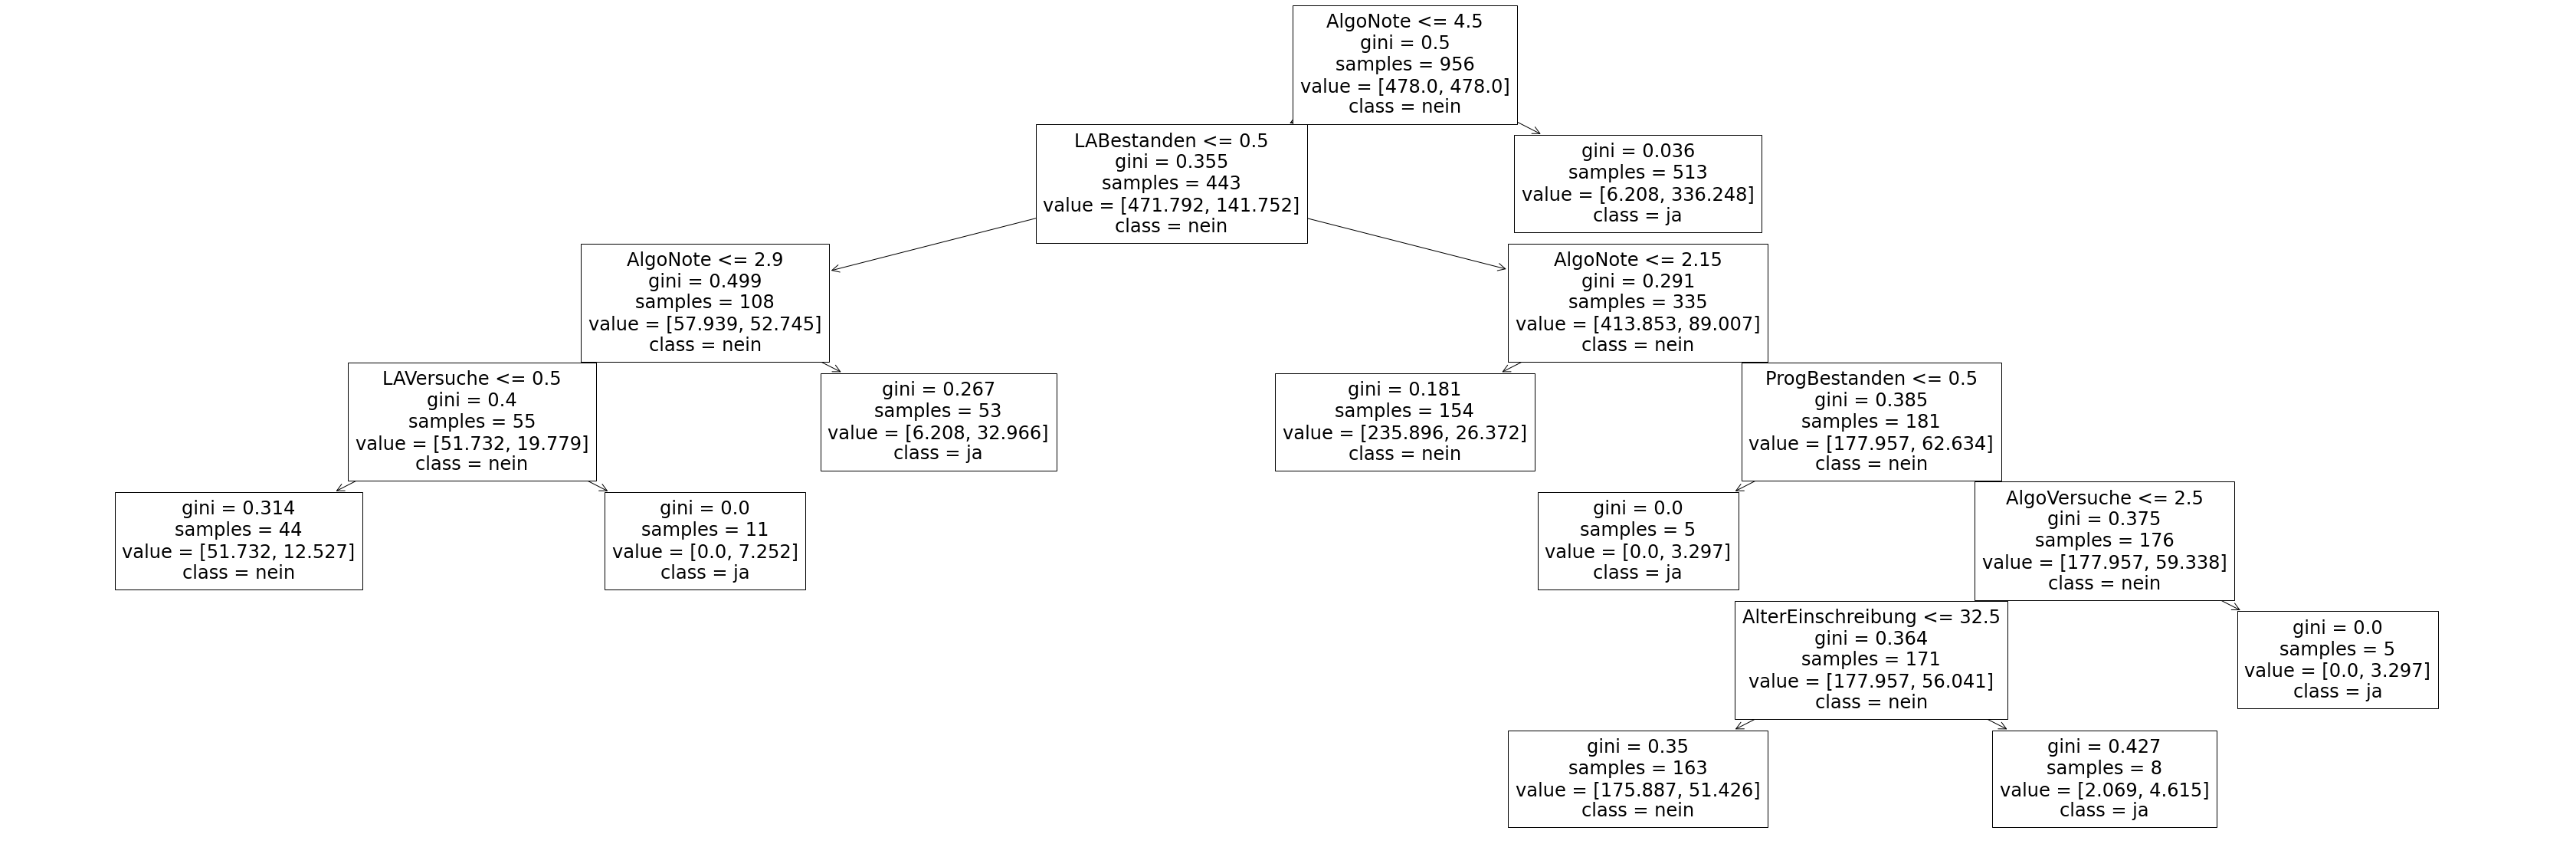

In [34]:
selected_ccp = 0.0029

clf = DecisionTreeClassifier(random_state=0, class_weight="balanced", min_impurity_decrease=0.001,
                             ccp_alpha=selected_ccp)
clf.fit(X_train, y_train)

eval_model(clf)
plot_tree(clf, feature_names = feature_names, class_names=["nein", "ja"])
plt.show()

### Dropping Algorithms and Data Structures

As Algorithms and Data Structures is a third semester module for the majority of students in the data base (only changed recently to a first-semester course), we can interpret some correlations regarding the third semester. For instance, students with calculus I failed tries but with a passing grade in algorithms are more probable to dropout somehow. In a last investigation for this data sheet, we will only concern ourselves with Programming and Calculus I.

In [35]:
df_classification = df_classification.drop(["AlgoBestanden", "AlgoVersuche", "AlgoNote"], axis=1)
df_classification.head()

,Deutsch,AlterEinschreibung,LABestanden,LAVersuche,ProgBestanden,ProgVersuche,ProgNote,Dropout,Männlich,Weiblich,Divers
0,1,35,1,1,1,1,2.7,0,1,0,0
1,1,20,1,1,1,1,3.7,0,0,1,0
2,1,20,1,1,0,0,5.0,1,0,1,0
3,1,20,0,0,1,2,3.3,1,1,0,0
4,1,19,1,2,1,1,3.3,0,1,0,0


In [36]:
X = df_classification.drop(["Dropout"], axis=1)
y = df_classification["Dropout"]

feature_names = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)


clf = DecisionTreeClassifier(random_state=0, class_weight="balanced", min_impurity_decrease=0.001)
clf.fit(X_train, y_train)
eval_model(clf)

# Trainset
Balanced accuracy: 0.868678907299597
Area under curve: 0.868678907299597
Confusion Matrix (tn, fp, fn, tp):
[[228   3]
 [181 544]]
# Testset
Balanced accuracy: 0.8137518319491939
Area under curve: 0.8137518319491939
Confusion Matrix (tn, fp, fn, tp):
[[ 81   8]
 [ 65 165]]


In [37]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
path

{'ccp_alphas': array([0.        , 0.00105128, 0.00106278, 0.00106963, 0.00110593,
        0.00129221, 0.00139628, 0.001857  , 0.00192001, 0.00209139,
        0.00237535, 0.00256575, 0.00262655, 0.00284736, 0.00348712,
        0.00358805, 0.00402234, 0.01260058, 0.01843787, 0.04016959,
        0.14468304]),
 'impurities': array([0.20212472, 0.203176  , 0.20423879, 0.20530842, 0.20641435,
        0.20770656, 0.20910284, 0.21095984, 0.21287985, 0.21497124,
        0.21734659, 0.21991233, 0.22253888, 0.2339283 , 0.23741543,
        0.24100348, 0.25307049, 0.27827164, 0.31514738, 0.35531696,
        0.5       ])}

Text(0, 0.5, 'Balanced Accuracy scores')

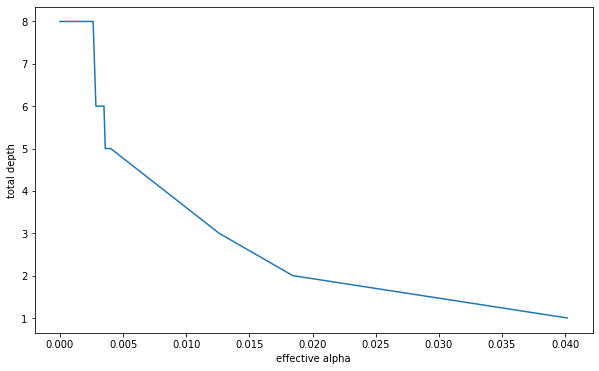

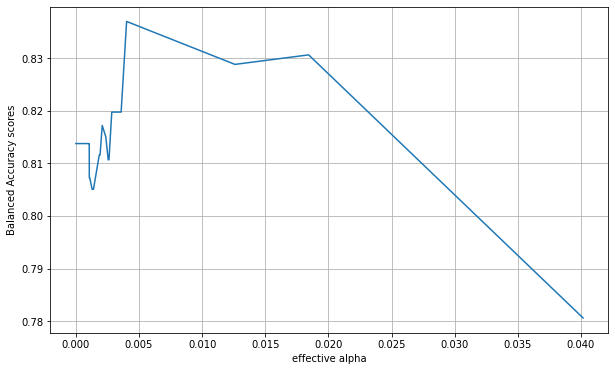

In [38]:
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha,
                                 class_weight="balanced", min_impurity_decrease=0.001)
    clf.fit(X_train, y_train)
    clfs.append(clf)

tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.plot(ccp_alphas[:-1], tree_depths[:-1])
plt.xlabel("effective alpha")
plt.ylabel("total depth")


acc_scores = [balanced_accuracy_score(y_test, clf.predict(X_test)) for clf in clfs]

plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas[:-1], acc_scores[:-1])
plt.xlabel("effective alpha")
plt.ylabel("Balanced Accuracy scores")


# Trainset
Balanced accuracy: 0.818662486938349
Area under curve: 0.818662486938349
Confusion Matrix (tn, fp, fn, tp):
[[217  14]
 [219 506]]
# Testset
Balanced accuracy: 0.8287982413287738
Area under curve: 0.8287982413287739
Confusion Matrix (tn, fp, fn, tp):
[[ 86   3]
 [ 71 159]]


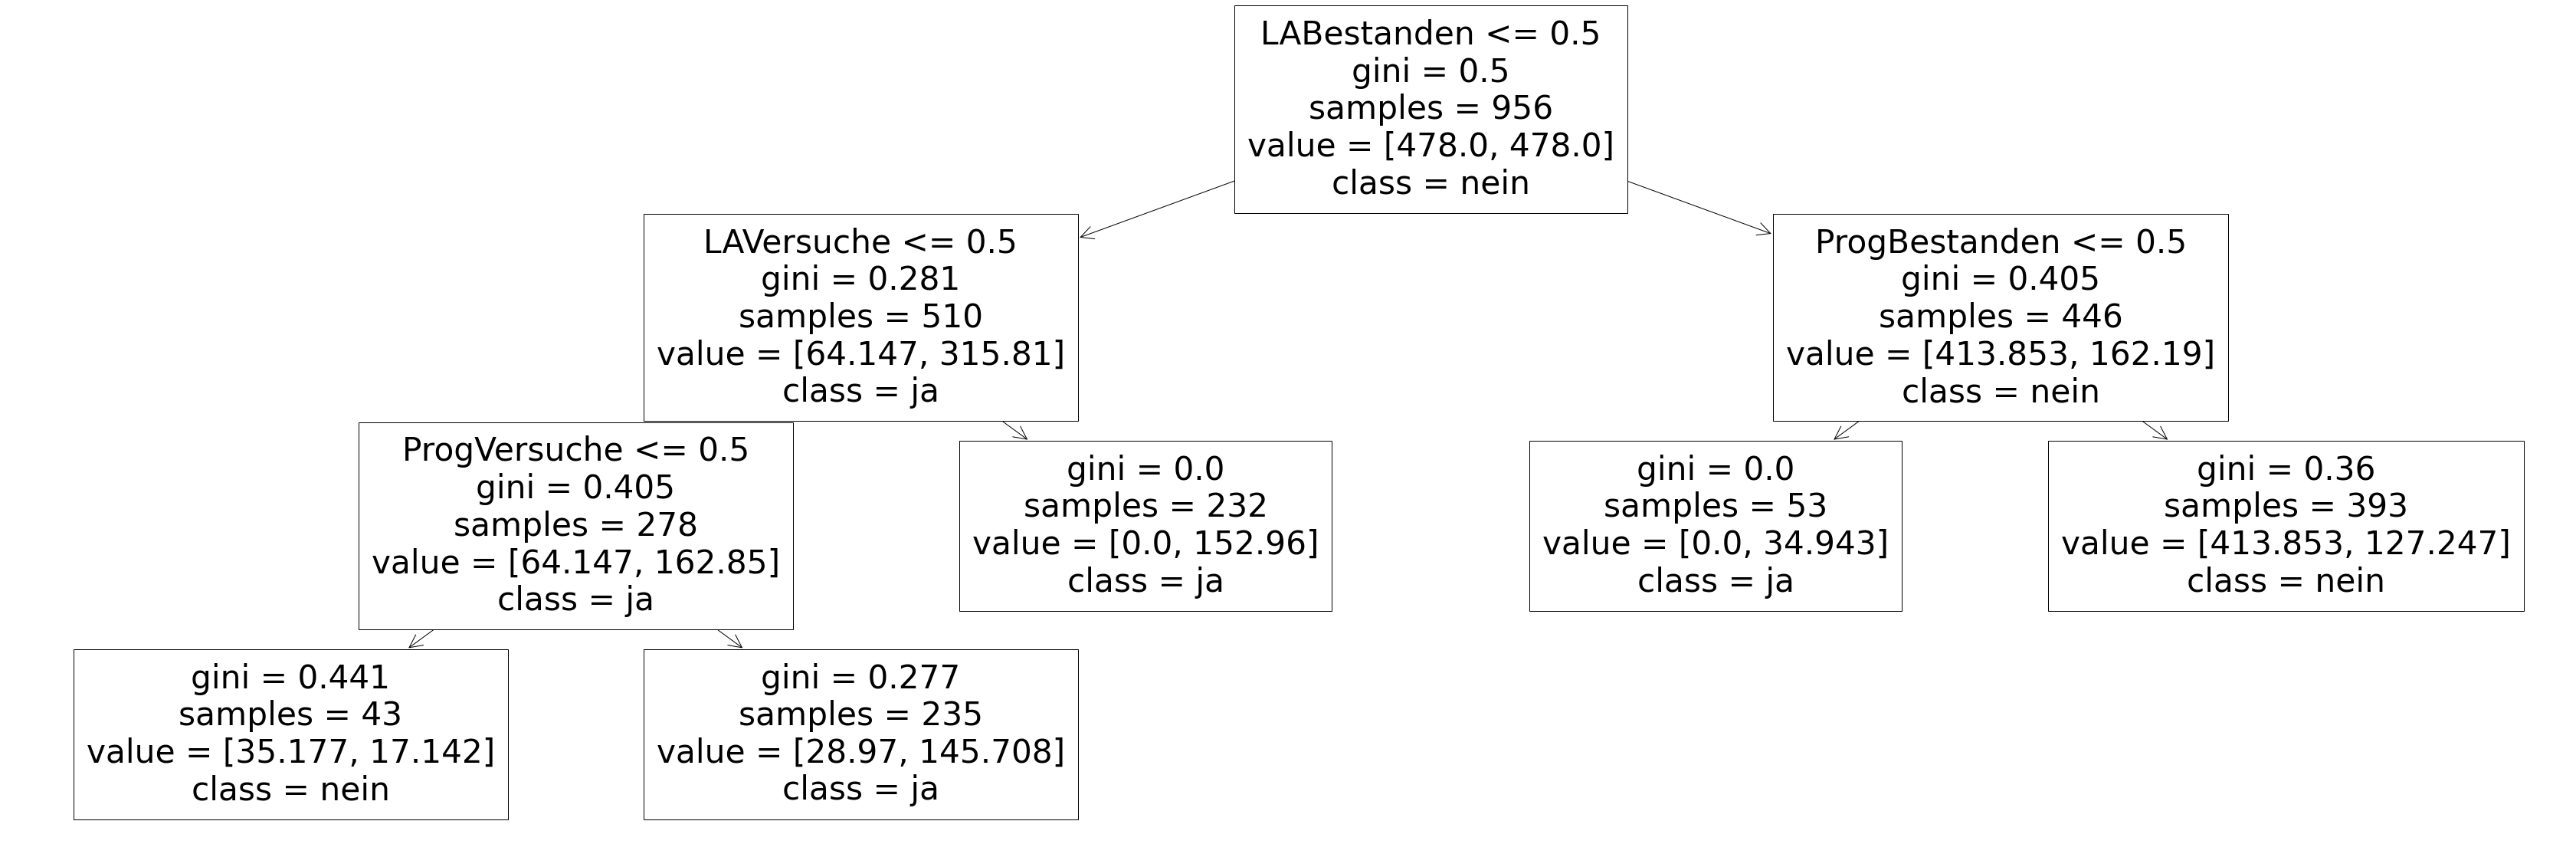

In [39]:
# selected_ccp = 0.004  # Alterantive with tree depth 4
selected_ccp = 0.0184  # Alternative value with tree depth 3

clf = DecisionTreeClassifier(random_state=0, class_weight="balanced", min_impurity_decrease=0.001,
                             ccp_alpha=selected_ccp)
clf.fit(X_train, y_train)

eval_model(clf)
plot_tree(clf, feature_names = feature_names, class_names=["nein", "ja"])
plt.show()
